In [1232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings("ignore")

# Dataset “blood” (X1 = систолическое давление (зависимая переменная), X2 = возраст пациента в годах, X3 = вес в фунтах (две независимые переменные)) #

In [1233]:
df = pd.read_csv("/kaggle/input/blood-dataset/blood.csv")

In [1234]:
df

,X1,X2,X3
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196
5,168,74,220
6,137,54,188
7,149,61,188
8,159,65,207
9,128,46,167


## Постройте модель ридж регрессии для X1 как функции от X2 и  X3. Используйте функции cv.plot и bias.plot для нахождения параметра k. ##

In [1235]:
X_cols = ["X2", "X3"]
y_col = "X1"

In [1236]:
def get_ridge_model(df, X_cols, y_col):
    X = sm.add_constant(df[X_cols])
    y = df[y_col]
    alphas = np.logspace(-4, 4, 100)

    # Создаем модель ридж регрессии с кросс-валидацией
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge_cv.fit(X, y)

    # Предсказание на тестовых данных
    y_pred = ridge_cv.predict(X)

    # Вычисляем среднеквадратичную ошибку
    mse = mean_squared_error(y, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Optimal alpha: {ridge_cv.alpha_}')


    # Визуализация кросс-валидации
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, ridge_cv.cv_values_.mean(axis=0), label='Cross-Validation MSE', color='blue')
    plt.axvline(ridge_cv.alpha_, color='red', linestyle='--', label='Optimal alpha')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.title('Ridge Regression Cross-Validation')
    plt.legend()
    plt.show()

    # Визуализация смещения и дисперсии
    bias = np.mean((y - y_pred)**2)
    variance = np.var(y_pred)

    print(f'Bias: {bias}')
    print(f'Variance: {variance}')
    return ridge_cv

Mean Squared Error: 4.219709970119724
Optimal alpha: 37.649358067924716


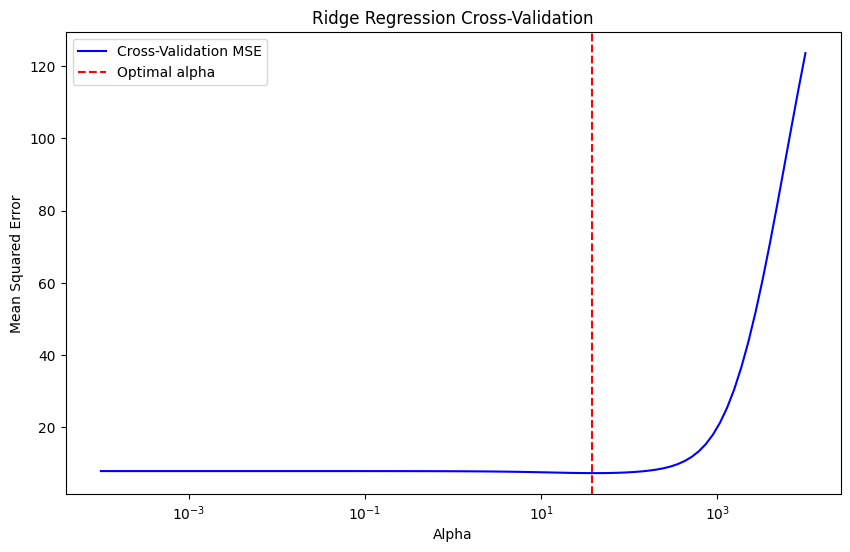

Bias: 4.219709970119724
Variance: 160.30823377886938


In [1237]:
model_ridge = get_ridge_model(df, X_cols, y_col)

## Проверьте мультиколлинеарность данных. ##

In [1238]:
def multicol(X):
    vif = pd.DataFrame()
    vif['variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

In [1239]:
multicol(df[X_cols])

  variable         VIF
0       X2  241.333801
1       X3  241.333801


## Проверьте значимость построенного уравнения регрессии. ##

In [1240]:
# Оценка значимости с помощью кросс-валидации
cv_scores = cross_val_score(ridge_cv, df[X_cols], df[y_col], cv=5, scoring='neg_mean_squared_error')
mean_cv_score = -np.mean(cv_scores)
print(f'Mean Cross-Validated MSE: {mean_cv_score}')

Mean Cross-Validated MSE: 7.822249846438652


## Проведите сравнительной анализ полученной модели с моделью линейной регрессии (когда оценки найдены по МНК). ##

In [1241]:
def get_linear_model(df, X_cols, y_col):
    X = sm.add_constant(df[X_cols])
    y = df[y_col]
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [1242]:
def compare_ridge_and_lin(df, X_cols, y_col, model_linear, model_ridge):
    X = sm.add_constant(df[X_cols])
    y = df[y_col]

    # Линейная регрессия
    y_pred_lin = model_linear.predict(X)
    mse_lin = mean_squared_error(y, y_pred_lin)

    # Ридж-регрессия
    y_pred_ridge = model_ridge.predict(X)
    mse_ridge = mean_squared_error(y, y_pred_ridge)
        
    # Вывод результатов
    print("Mean Squared Error (Linear Regression):", mse_lin)
    print("Mean Squared Error (Ridge Regression):", mse_ridge)

    models = ['Linear Regression', 'Ridge Regression']
    cols = ['const', 'X2', 'X3']
    
    linear_coefs = model_linear.params
    ridge_coefs = model_ridge.coef_
    y = np.array([linear_coefs, ridge_coefs])

    plt.figure(figsize=(10, 10))
    for i in range(len(y[0])):  # Для каждого коэффициента
        plt.plot(models, y[:, i], marker='o', label=cols[i])

    plt.title('Coefficient Estimates')
    plt.xlabel('Model')
    plt.ylabel('Coefficient Value')
    plt.grid()
    plt.legend()
    plt.show()

Mean Squared Error (Linear Regression): 3.9084384349407344
Mean Squared Error (Ridge Regression): 4.219709970119724


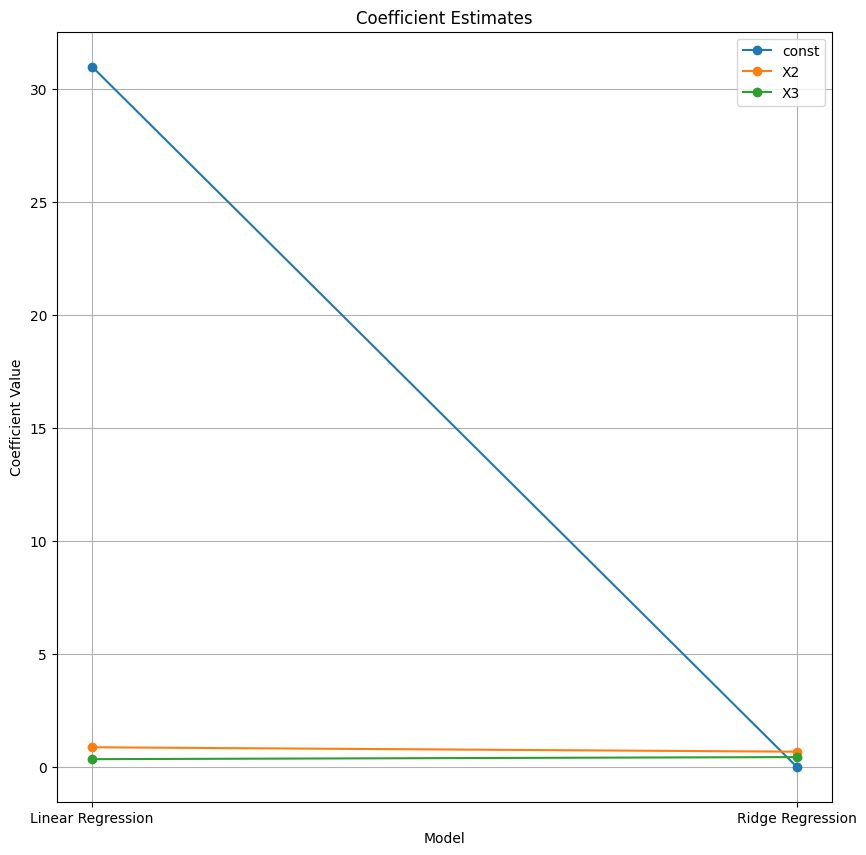

In [1243]:
model_linear = get_linear_model(df, X_cols, y_col)
compare_ridge_and_lin(df, X_cols, y_col, model_linear, model_ridge)

# Dataset “kuiper” (price – зависимая переменная, mileage, liter, cruise, sound, leather – независимые переменные) #

In [1244]:
df = pd.read_csv("/kaggle/input/kuiper-dataset/kuiper.csv")

In [1245]:
df

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,0,0
800,16175.957604,19095,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
801,15731.132897,20484,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
802,15118.893228,25979,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0


## Постройте квантильную регрессию для различных значений параметров «тау», Y = price – зависимая переменная, mileage, liter, cruise, sound, leather – независимые переменные). ##

In [1246]:
X_cols = ["Mileage", "Liter", "Cruise", "Sound", "Leather"]
y_col = "Price"
X = df[X_cols]
y = df[y_col]

In [1247]:
def get_quantile_model(df, X_cols, y_col, tau):
    X = sm.add_constant(df[X_cols])
    y = df[y_col]
    model = sm.QuantReg(y, X).fit(q=tau)
    return model

In [1248]:
def get_quantile_models_and_coefs(df, X_cols, y_col):
    X = sm.add_constant(df[X_cols])
    y = df[y_col]

    taus = np.arange(0.1, 1.0, 0.1)

    models = {}
    coefficients = {}
    
    for tau in taus:
        model = get_quantile_model(df, X_cols, y_col, tau)
        models[tau] = model
        coefficients[tau] = model.params

    # Преобразование коэффициентов в DataFrame для удобства
    coefficients_df = pd.DataFrame(coefficients).T
    coefficients_df.columns = ['const', 'Mileage', 'Liter', 'Cruise', 'Sound', 'Leather']
    return models, coefficients_df

In [1249]:
models, coefficients_df = get_quantile_models_and_coefs(df, X_cols, y_col)
for tau, model in models.items():
    print(f"tau: {tau}")
    print(model.summary())

tau: 0.1
                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3496
Model:                       QuantReg   Bandwidth:                       3644.
Method:                 Least Squares   Sparsity:                    1.013e+04
Date:                Sun, 15 Dec 2024   No. Observations:                  804
Time:                        18:00:57   Df Residuals:                      798
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6262.3866    454.817     13.769      0.000    5369.607    7155.166
Mileage       -0.1094      0.013     -8.357      0.000      -0.135      -0.084
Liter       3337.5496     92.968     35.900      0.000    3155.058    3520.041
Cruise       479.4633    280.258      1.711

## Изобразите результаты на графиках. ##

In [1250]:
def plot_quantile_regression(coefficients_df):
    # Визуализация изменения коэффициентов
    plt.figure(figsize=(12, 8))
    for col in coefficients_df.columns:
        plt.plot(coefficients_df.index, coefficients_df[col], marker='o', label=col)

    plt.title('Coefficient Estimates for Quantile Regression')
    plt.xlabel('Tau')
    plt.ylabel('Coefficient Value')
    plt.xticks(coefficients_df.index)
    plt.grid()
    plt.legend()
    plt.show()

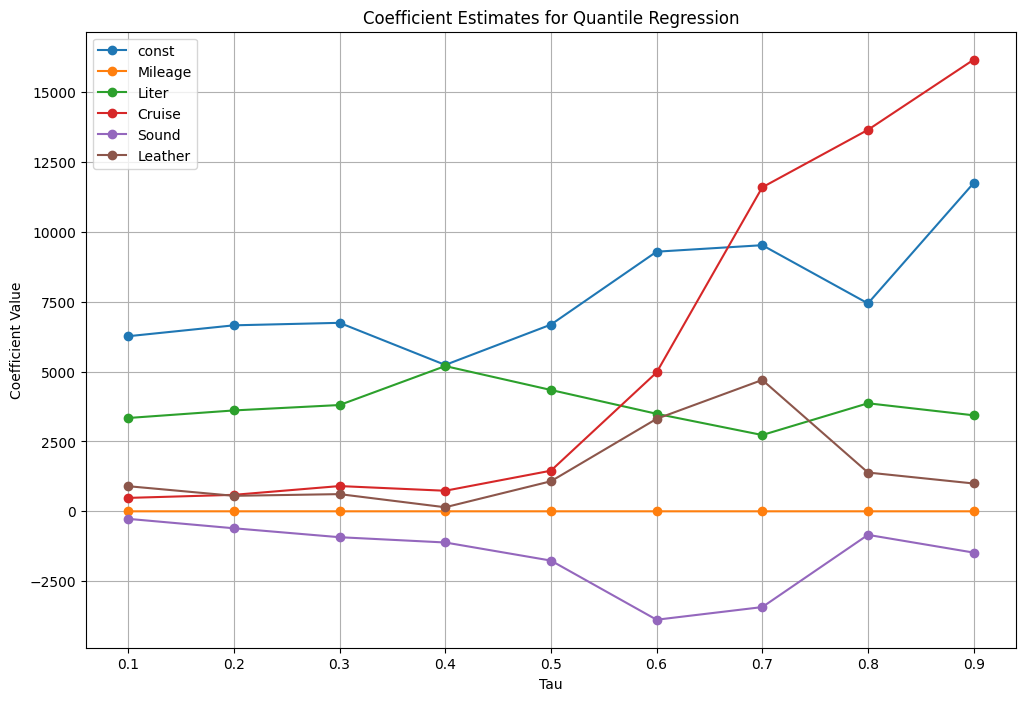

In [1251]:
plot_quantile_regression(coefficients_df)

## Постройте модель линейной регрессии и сравните эту модель с моделью медианной регрессии. ##

In [1252]:
def compare_med_and_lin(df, X_col, y_col):
    X = sm.add_constant(df[X_col])
    y = df[y_col]
    
    linear_model = get_linear_model(df, X_col, y_col)
    quantile_model = get_quantile_model(df, X_col, y_col, 0.5)
    
    y_pred_linear = linear_model.predict(X)
    y_pred_quantile = quantile_model.predict(X)
    
    plt.figure(figsize=(12, 8))
    sns.regplot(x=X_col, y=y_col, data=df, fit_reg=False)
    plt.plot(df[X_col], y_pred_linear, color='blue', label='Linear Regression Line')
    plt.plot(df[X_col], y_pred_quantile, color='red', label='Median Regression Line')
    plt.xlabel('Mileage')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Вывод результатов моделей
    print('OLS Regression Results:')
    print(ols_model.summary())

    print('\nMedian Regression Results (Quantile 0.5):')
    print(quantile_model.summary())

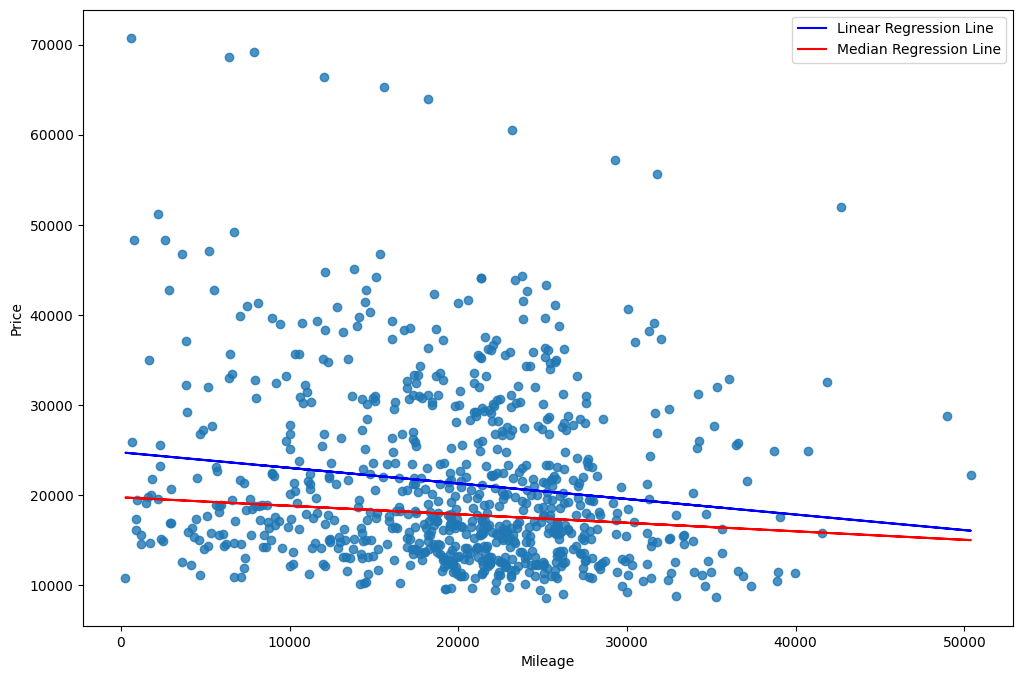

OLS Regression Results:
                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.665
Method:                 Least Squares   F-statistic:                              1598.
Date:                Sun, 15 Dec 2024   Prob (F-statistic):                   3.43e-193
Time:                        18:00:58   Log-Likelihood:                         -8793.2
No. Observations:                 804   AIC:                                  1.759e+04
Df Residuals:                     803   BIC:                                  1.759e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [1253]:
compare_med_and_lin(df, 'Mileage', y_col)

# Dataset “cigarettes”: (переменные по столбцам: carbon monoxide, tar, nicotine, weight) #

In [1254]:
df = pd.read_csv("/kaggle/input/cigar-dataset/cigarettes.csv")

In [1255]:
df

,mark,carbon monoxide,tar,nicotine,weight
0,Alpine,14.1,0.86,0.9853,13.6
1,Benson&Hedges,16.0,1.06,1.0938,16.6
2,BullDurham,29.8,2.03,1.1650,23.5
3,CamelLights,8.0,0.67,0.9280,10.2
4,Carlton,4.1,0.40,0.9462,5.4
5,Chesterfield,15.0,1.04,0.8885,15.0
6,GoldenLights,8.8,0.76,1.0267,9.0
7,Kent,12.4,0.95,0.9225,12.3
8,Kool,16.6,1.12,0.9372,16.3
9,L&M,14.9,1.02,0.8858,15.4


## Постройте несколько моделей нелинейной (квадратичной и кубической) регрессии с зависимой переменной y=carbon monoxide, и независимыми переменными:  x1=tar, x2=nicotine, x3=weight. Постройте модель линейной регрессии и сравните эту модель с моделями нелинейной регрессии. ##

In [1256]:
X_cols = ['tar', 'nicotine', 'weight']
y_col = "carbon monoxide"

In [1257]:
def get_X_poly(X, degree_):
    poly = PolynomialFeatures(degree=degree_, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_poly = sm.add_constant(X_poly)
    return X_poly

In [1258]:
def get_poly_model(df, X_cols, y_col, degree_):
    X = df[X_cols]
    y = df[y_col]
    X_poly = get_X_poly(X, degree_)
    
    model = sm.OLS(y, X_poly)
    results = model.fit()
    return results

In [1259]:
model_linear = get_poly_model(df, X_cols, y_col, 1)
model_quad = get_poly_model(df, X_cols, y_col, 2)
model_cubic = get_poly_model(df, X_cols, y_col, 3)

In [1260]:
def print_equation(results):
    coefficients = results.params
    # Свободный член
    intercept = coefficients[0]
    # Коэффициенты при признаках
    slopes = coefficients[1:]
    
    equation = f"y = {intercept:.3f}"
    for i, slope in enumerate(slopes):
        equation += f" + ({slope:.3f}) * x{i+1}"

    print("Уравнение регрессии:")
    print(equation)

In [1261]:
print_equation(model_linear)
print_equation(model_quad)
print_equation(model_cubic)

Уравнение регрессии:
y = -2.370 + (10.080) * x1 + (0.170) * x2 + (0.446) * x3
Уравнение регрессии:
y = 30.834 + (-48.695) * x1 + (-57.993) * x2 + (3.739) * x3 + (-14.394) * x4 + (61.722) * x5 + (1.600) * x6 + (22.758) * x7 + (-3.158) * x8 + (-0.054) * x9
Уравнение регрессии:
y = 220.181 + (-318.517) * x1 + (-574.653) * x2 + (14.804) * x3 + (658.954) * x4 + (1018.821) * x5 + (-120.308) * x6 + (395.447) * x7 + (-44.654) * x8 + (4.925) * x9 + (-78.753) * x10 + (-641.976) * x11 + (15.237) * x12 + (-649.188) * x13 + (109.775) * x14 + (-0.598) * x15 + (-28.115) * x16 + (23.327) * x17 + (-3.923) * x18 + (-0.015) * x19


In [1262]:
def compare_poly_models(df, X_cols, y_col, model_linear, model_quad, model_cubic):
    X = df[X_cols]
    y = df[y_col]

    X_linear = get_X_poly(X, 1)
    X_quad = get_X_poly(X, 2)
    X_cubic = get_X_poly(X, 3)

    # Предсказания
    y_pred_linear = model_linear.predict(X_linear)
    y_pred_quad = model_quad.predict(X_quad)
    y_pred_cubic = model_cubic.predict(X_cubic)

    # Метрики качества
    rmse_linear = mean_squared_error(y, y_pred_linear, squared=False)
    rmse_quad = mean_squared_error(y, y_pred_quad, squared=False)
    rmse_cubic = mean_squared_error(y, y_pred_cubic, squared=False)

    # Вывод графиков регрессии
    for col in X_cols:
        sns.regplot(data=df, x=col, y=y_col, order=2, color="red")
        sns.regplot(data=df, x=col, y=y_col, order=3, color="blue")
        sns.regplot(data=df, x=col, y=y_col, color="green")
        plt.show()
        
    # Вывод метрик
    print("\nСравнение моделей:")
    print(f"Линейная модель: R^2 = {model_linear.rsquared:.4f}, RMSE = {rmse_linear:.4f}")
    print(f"Квадратичная модель: R^2 = {model_quad.rsquared:.4f}, RMSE = {rmse_quad:.4f}")
    print(f"Кубическая модель: R^2 = {model_cubic.rsquared:.4f}, RMSE = {rmse_cubic:.4f}")

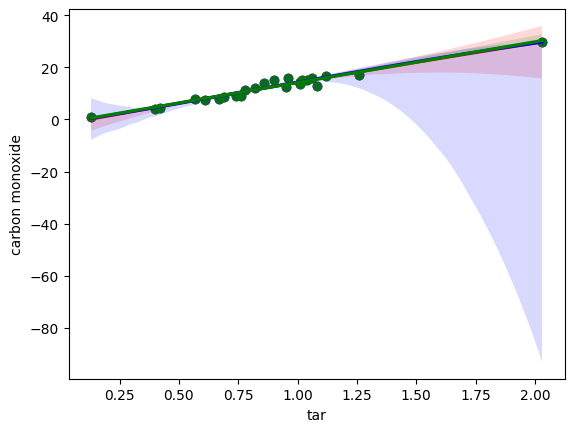

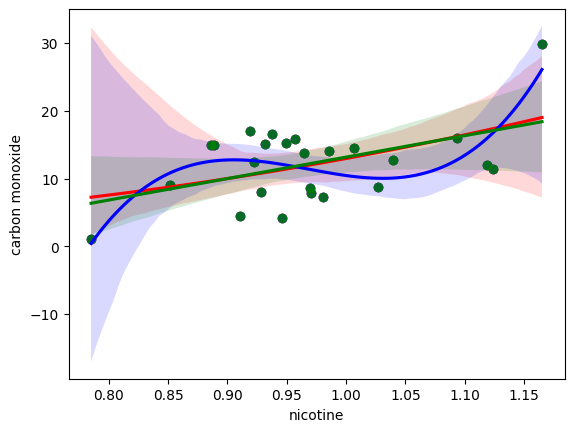

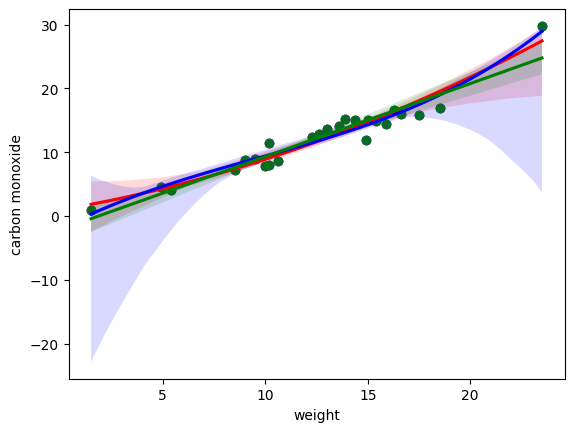


Сравнение моделей:
Линейная модель: R^2 = 0.9736, RMSE = 0.9018
Квадратичная модель: R^2 = 0.9820, RMSE = 0.7448
Кубическая модель: R^2 = 0.9955, RMSE = 0.3733


In [1263]:
compare_poly_models(df, X_cols, y_col, model_linear, model_quad, model_cubic)